In [9]:
# %load /home/glebi/git/experiment-automation/processing_tools.py
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import scienceplots

plt.style.use(['science', 'russian-font'])
plt.style.use(["bright"])

matplotlib.rcParams.update({
    'figure.figsize': [6, 4],
    'savefig.facecolor': 'white',
    'figure.dpi': 200.0,
    'font.size': 12.0,
})

def line_func(x, arg1, arg2):
    return x * arg1 + arg2

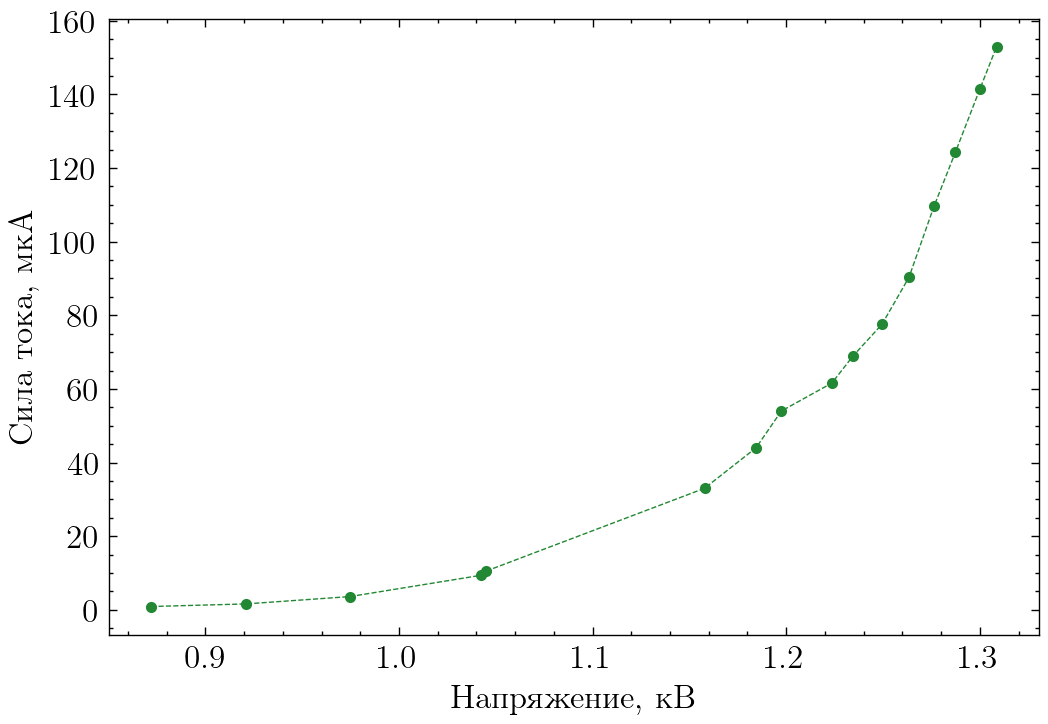

In [10]:
df = pd.read_csv("VAH.csv")
cols = df.columns

plt.plot(df[cols[0]] * 1e-3, df[cols[1]]*1e-1, marker=".", lw=.5, color="C2", ls="--")
plt.xlabel("Напряжение, кВ")
plt.ylabel("Сила тока, мкА")

plt.savefig("hand-VAH.png")
plt.show()

сопротивление нашей цепи

In [11]:
1263.4 / (903e-7)

13991140.642303433

максимальное напряжение на резисторе, который снимает ток

In [12]:
1600e-7 * 52e3

8.32

аналитическая функция вах

In [13]:
# def vah_func(u):
#     return S_e * (1.537e10 / )

обработка данных

In [14]:
U_min = 900
R = 26.99e3 # Ом

column_names = ["Voltage", "Current"]

experiment_names = ["Первая серия измерений", "Вторая серия измерений"]
file_idxs = [[1, 2, 3], [4, 5]]

dots_result = [None, None]
ex_result = [None, None]

for num, (ex_name, f_idxs) in enumerate(zip(experiment_names, file_idxs)):
    result = pd.DataFrame(columns=column_names)

    for i in f_idxs:
        df = pd.read_csv(f"RISING-{i}.csv", header = None)
        df = df.loc[lambda x : x[4] > U_min]

        U = df[4] # В
        U_cur = df[10]
        I = U_cur / R # А

        result = pd.concat([result, pd.concat(dict(zip(column_names, [U, I])), axis=1)], ignore_index=True)
    
    result["Current"] -= min(result["Current"])
    ex_result[num] = result.groupby("Voltage").mean().reset_index()
    dots_result[num] = result

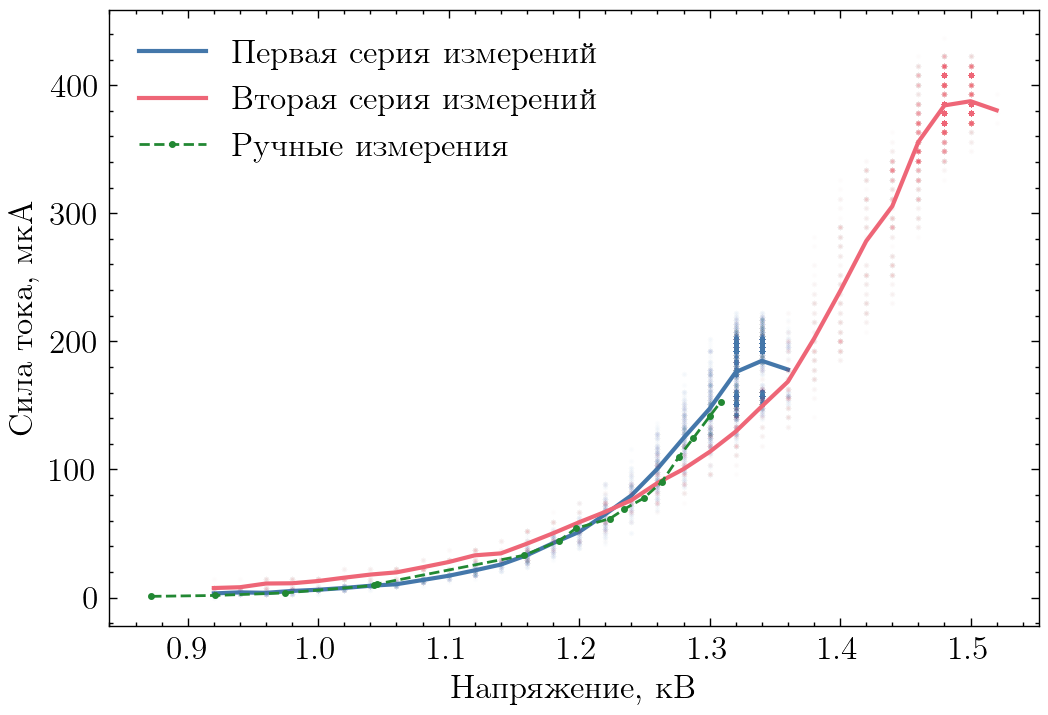

In [15]:
for num, (ex_name, dots, line) in enumerate(zip(experiment_names, dots_result, ex_result)):
    plt.plot(dots["Voltage"]*1e-3, dots["Current"]*1e6, alpha=0.01, ls="", marker=".", markersize=2, color=f"C{num}")
    plt.plot(line["Voltage"]*1e-3, line["Current"]*1e6, lw=1.5, alpha=1, color=f"C{num}", label=ex_name)
else:
    df = pd.read_csv("VAH.csv")
    cols = df.columns
    plt.plot(df[cols[0]]*1e-3, df[cols[1]]*1e-1, marker=".", lw=1, markersize=3, ls="--", color="C2", label="Ручные измерения")
    
plt.xlabel(fr"Напряжение, кВ")
plt.ylabel(fr"Сила тока, мкА")
# plt.yscale("log")

plt.legend()
plt.savefig("all-VAH.png")
plt.show()

### Прямые с осциллографа

0:     k= -10.50	b= -15.26
1:     k= -7.50	b= -17.57


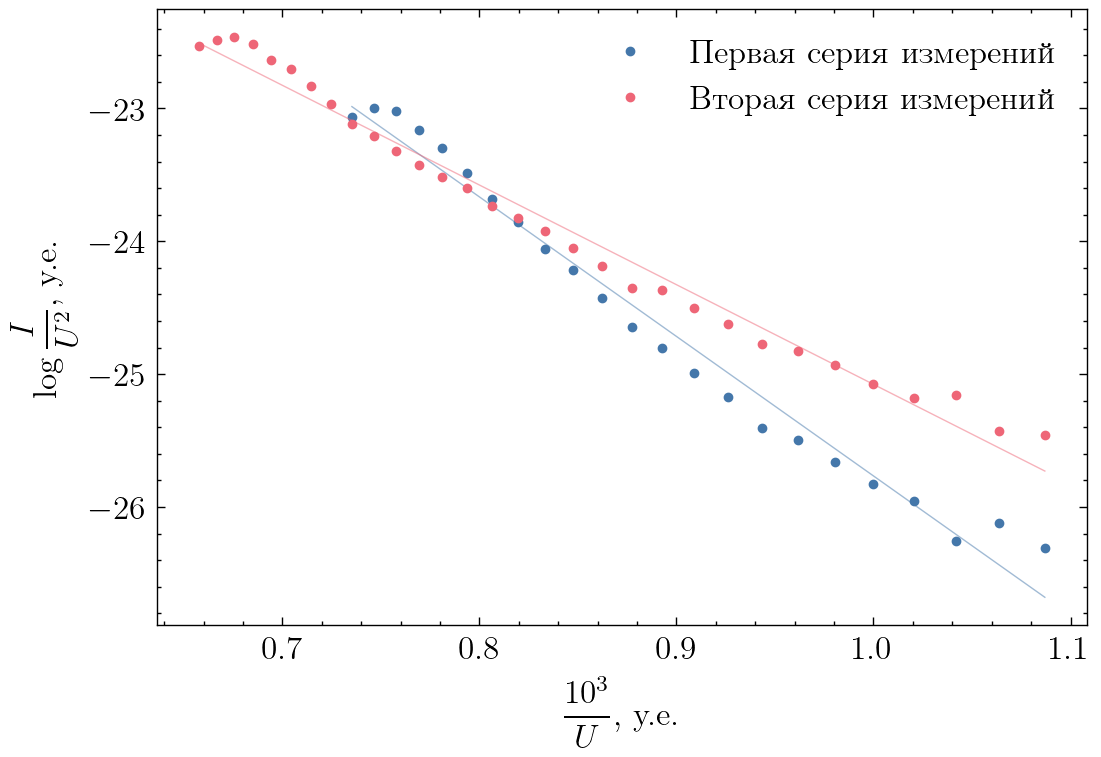

In [16]:
opt_arr = []
for num, (ex_name, line) in enumerate(zip(experiment_names, ex_result)):
    x = 1e3 / line["Voltage"]
    y = np.log(line["Current"]) - 2 * np.log(line["Voltage"])
    
    popt, pcov = curve_fit(line_func, x, y)
    print(f"{num}:     k= {popt[0]:.2f}\tb= {popt[1]:.2f}")
    opt_arr.append(popt)
    
    plt.plot(x, y, ls="", marker=".", markersize=5, color=f"C{num}", label=ex_name)
    plt.plot(x, line_func(x, *popt), lw=0.5, alpha=.5, color=f"C{num}")

plt.xlabel(r"$\dfrac {10^3} U$, у.е.")
plt.ylabel(r"$\log \dfrac I {U^2}$, у.е.")

plt.legend()
plt.savefig("osc-NORDGAME-FAULER.png")
plt.show()

### Прямая ручная

1:     k= -11.41	b= -14.52


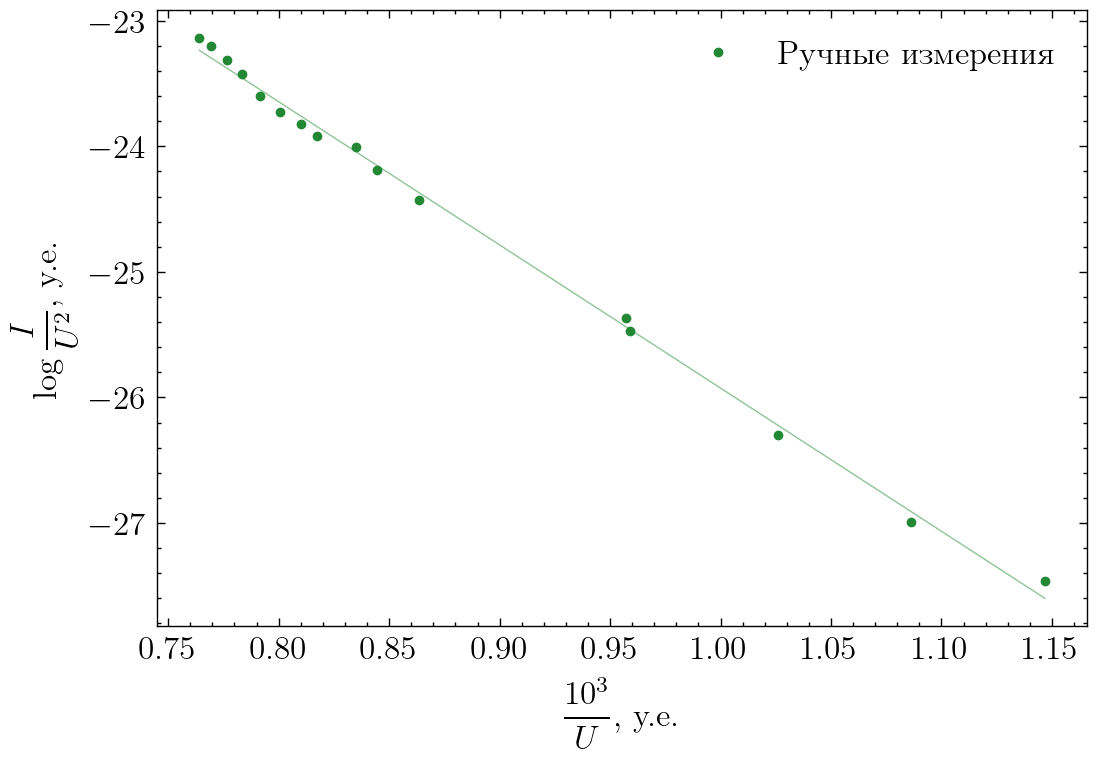

In [17]:
df = pd.read_csv("VAH.csv")
cols = df.columns

volt_h = df[cols[0]]
curr_h = df[cols[1]]*1e-7

x = 1e3 / volt_h
y = np.log(curr_h) - 2 * np.log(volt_h)

popt, pcov = curve_fit(line_func, x, y)
print(f"{num}:     k= {popt[0]:.2f}\tb= {popt[1]:.2f}")
opt_arr.append(popt)

plt.plot(x, y, ls="", marker=".", markersize=5, color=f"C2", label="Ручные измерения")
plt.plot(x, line_func(x, *popt), lw=0.5, alpha=.5, color=f"C2")

plt.xlabel(r"$\dfrac {10^3} U$, у.е.")
plt.ylabel(r"$\log \dfrac I {U^2}$, у.е.")

plt.legend()
plt.savefig("hand-NORDGAME-FAULER.png")
plt.show()

### Все вместе

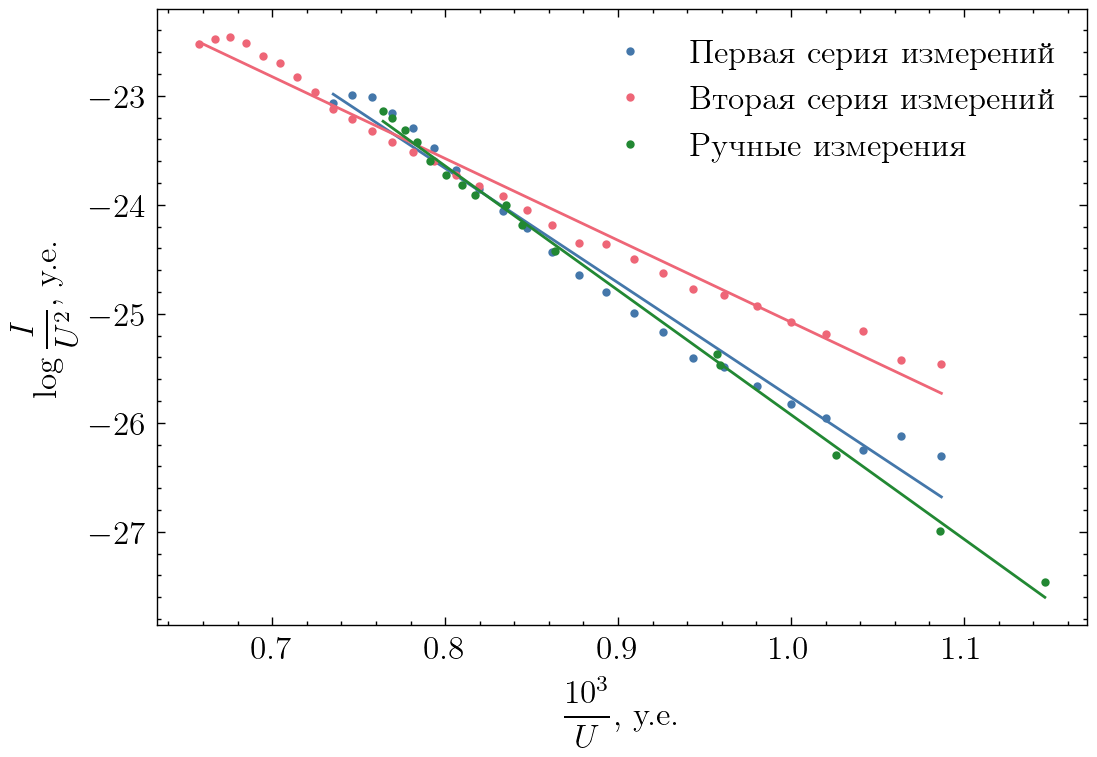

In [18]:
for num, (ex_name, line) in enumerate(zip(experiment_names, ex_result)):
    x = 1e3 / line["Voltage"]
    y = np.log(line["Current"]) - 2 * np.log(line["Voltage"])
    
    plt.plot(x, y, ls="", marker=".", markersize=4, color=f"C{num}", label=ex_name)
    plt.plot(x, line_func(x, *(opt_arr[num])), lw=1, color=f"C{num}")
else:
    x = 1e3 / volt_h
    y = np.log(curr_h) - 2 * np.log(volt_h)

    plt.plot(x, y, ls="", marker=".", markersize=4, color=f"C2", label="Ручные измерения")
    plt.plot(x, line_func(x, *(opt_arr[-1])), lw=1, color=f"C2")
    
plt.xlabel(r"$\dfrac {10^3} U$, у.е.")
plt.ylabel(r"$\log \dfrac I {U^2}$, у.е.")

plt.legend()
plt.savefig("osc-NORDGAME-FAULER.png")
plt.show()

Угол наклона полученной прямой получается по формуле

$\tan \alpha = -0.683 \cdot \dfrac {\phi^\frac 3 2} \beta$

зная $\phi = 4.5$ эВ -- работу выхода, находим $\beta$ -- форм-фактор острия:

In [19]:
for opt in opt_arr:
    tan_a = opt[0]
    beta = -0.683 * (4.5**(3/2)) / tan_a
    print(f"beta:\t{beta:.2e}")

beta:	6.21e-01
beta:	8.69e-01
beta:	5.71e-01


# тоже самое, но для каждого файла в отдельности

In [20]:
file_names = [f"RISING-{i}.csv" for i in range(1, 6)] + [f"BOTH-{i}.csv" for i in range(1, 4)]
file_names

['RISING-1.csv',
 'RISING-2.csv',
 'RISING-3.csv',
 'RISING-4.csv',
 'RISING-5.csv',
 'BOTH-1.csv',
 'BOTH-2.csv',
 'BOTH-3.csv']

In [21]:
U_min = 900
R = 26.99e3 # Ом

column_names = ["Voltage", "Current"]
dots_result = []

for num, f_name in enumerate(file_names):
    result = pd.DataFrame(columns=column_names)

    df = pd.read_csv(f_name, header = None)
    df = df.loc[lambda x : x[4] > U_min]

    U = df[4] # В
    U_cur = df[10]
    I = U_cur / R # А

    result = pd.concat([result, pd.concat(dict(zip(column_names, [U, I])), axis=1)], ignore_index=True)
    
    result["Current"] -= min(result["Current"])
    dots_result.append(result.groupby("Voltage").mean().reset_index())

0:     k= -15.31	b= -11.32
1:     k= -10.81	b= -14.96
2:     k= -15.25	b= -11.58
3:     k= -10.82	b= -15.03
4:     k= -7.69	b= -17.53
5:     k= -7.45	b= -17.89
6:     k= -7.95	b= -17.49
7:     k= -7.96	b= -17.50


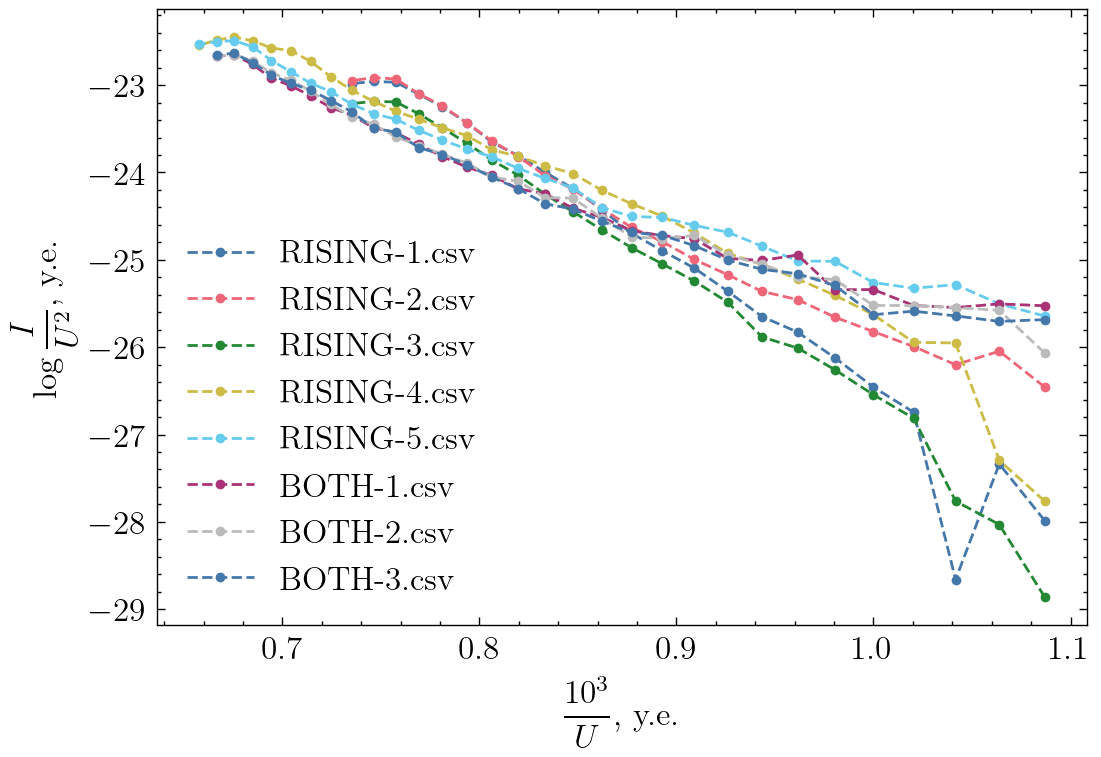

In [22]:
opt_arr = []
for num, (f_name, line) in enumerate(zip(file_names, dots_result)):
    x = 1e3 / line["Voltage"]
    y = np.log(line["Current"]) - 2 * np.log(line["Voltage"])
    
    popt, pcov = curve_fit(line_func, x, y)
    print(f"{num}:     k= {popt[0]:.2f}\tb= {popt[1]:.2f}")
    opt_arr.append(popt)
    
    plt.plot(x, y, ls="--", marker=".", markersize=5, color=f"C{num}", label=f_name)
    # plt.plot(x, line_func(x, *popt), lw=0.5, alpha=.5, color=f"C{num}")

plt.xlabel(r"$\dfrac {10^3} U$, у.е.")
plt.ylabel(r"$\log \dfrac I {U^2}$, у.е.")

plt.legend()
plt.savefig("separ-NORDGAME-FAULER.png")
plt.show()

In [23]:
opt_arr = np.array(opt_arr)
k_arr = opt_arr.T[0]
b_arr = opt_arr.T[1]

In [53]:
from tabulate import tabulate
print(tabulate(opt_arr.T, tablefmt="latex", floatfmt=".2f"))

\begin{tabular}{rrrrrrrr}
\hline
 -15.31 & -10.81 & -15.25 & -10.82 &  -7.69 &  -7.45 &  -7.95 &  -7.96 \\
 -11.32 & -14.96 & -11.58 & -15.03 & -17.53 & -17.89 & -17.49 & -17.50 \\
\hline
\end{tabular}


### Первый и второй случаи (b от ln -k)

k= 8.97	b= -36.05


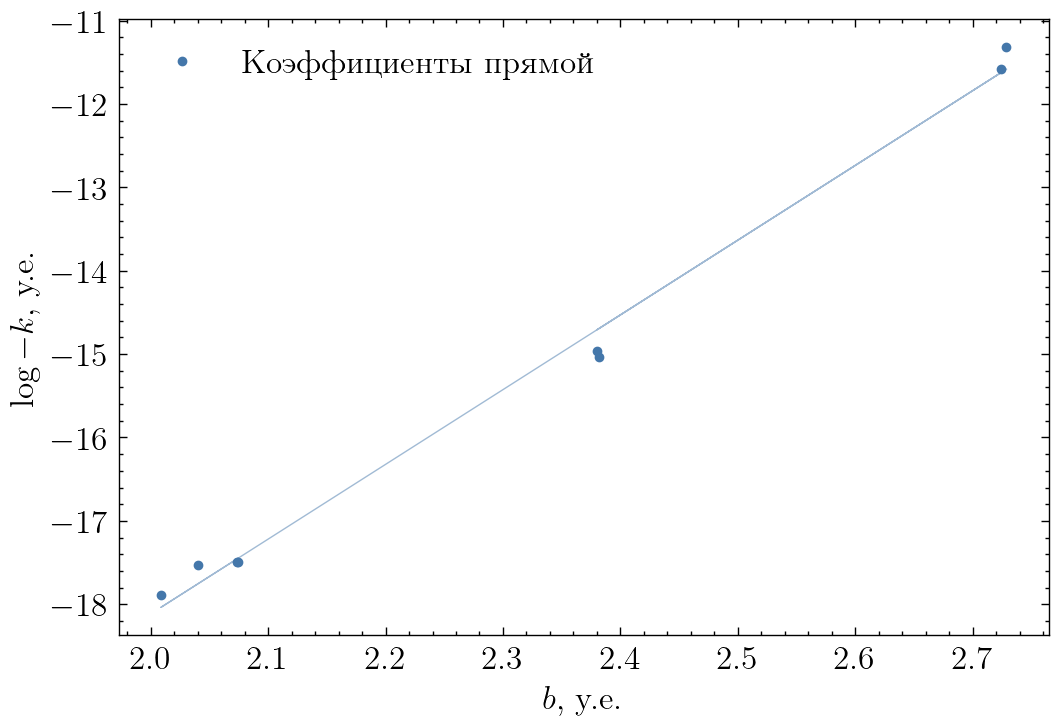

In [54]:
x = np.log(-k_arr)
y = b_arr

popt, pcov = curve_fit(line_func, x, y)
print(f"k= {popt[0]:.2f}\tb= {popt[1]:.2f}")

plt.plot(x, y, ls="", marker=".", markersize=5, color=f"C0", label="Коэффициенты прямой")
plt.plot(x, line_func(x, *popt), lw=0.5, alpha=.5, color=f"C0")

plt.xlabel(r"$b$, у.е.")
plt.ylabel(r"$\log -k$, у.е.")

plt.legend()
plt.savefig("separ-1-KOEF.png")
plt.show()

### Третий случай (b + 2 * log(-k) от exp(-b / 2))

k= -0.00	b= -6.90


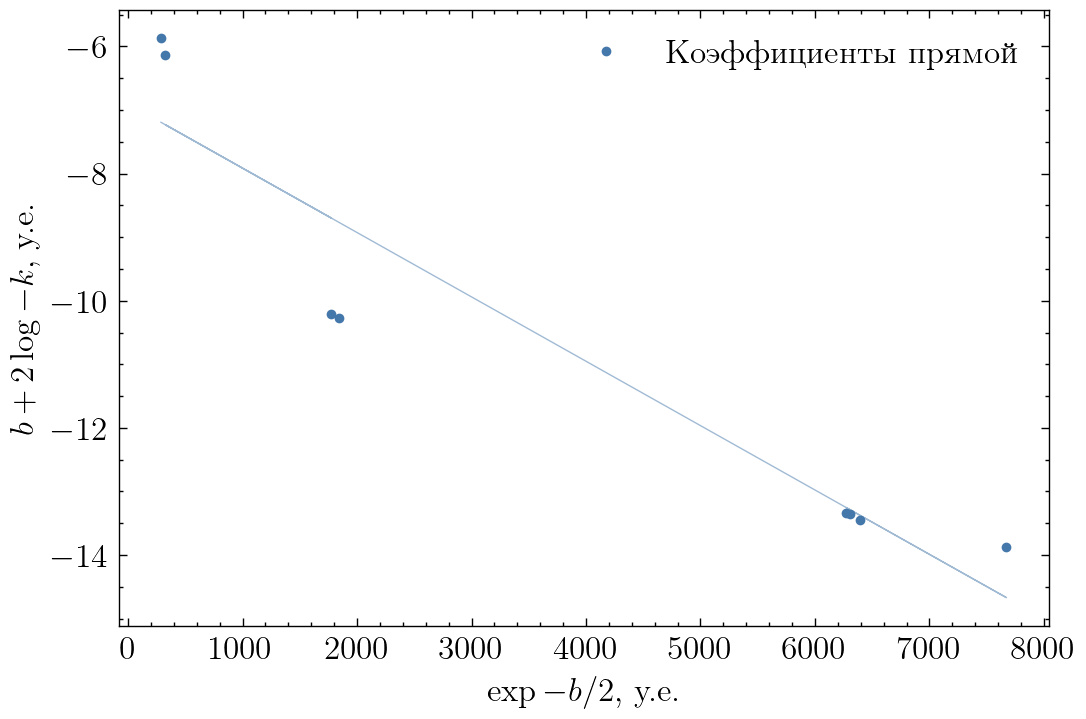

In [55]:
x = np.exp(-b_arr / 2)
y = b_arr + 2 * np.log(-k_arr)

popt, pcov = curve_fit(line_func, x, y)
print(f"k= {popt[0]:.2f}\tb= {popt[1]:.2f}")

plt.plot(x, y, ls="", marker=".", markersize=5, color=f"C0", label="Коэффициенты прямой")
plt.plot(x, line_func(x, *popt), lw=0.5, alpha=.5, color=f"C0")

plt.xlabel(r"$\exp{-b / 2}$, у.е.")
plt.ylabel(r"$b + 2\log{-k}$, у.е.")

plt.legend()
plt.savefig("separ-3-KOEF.png")
plt.show()

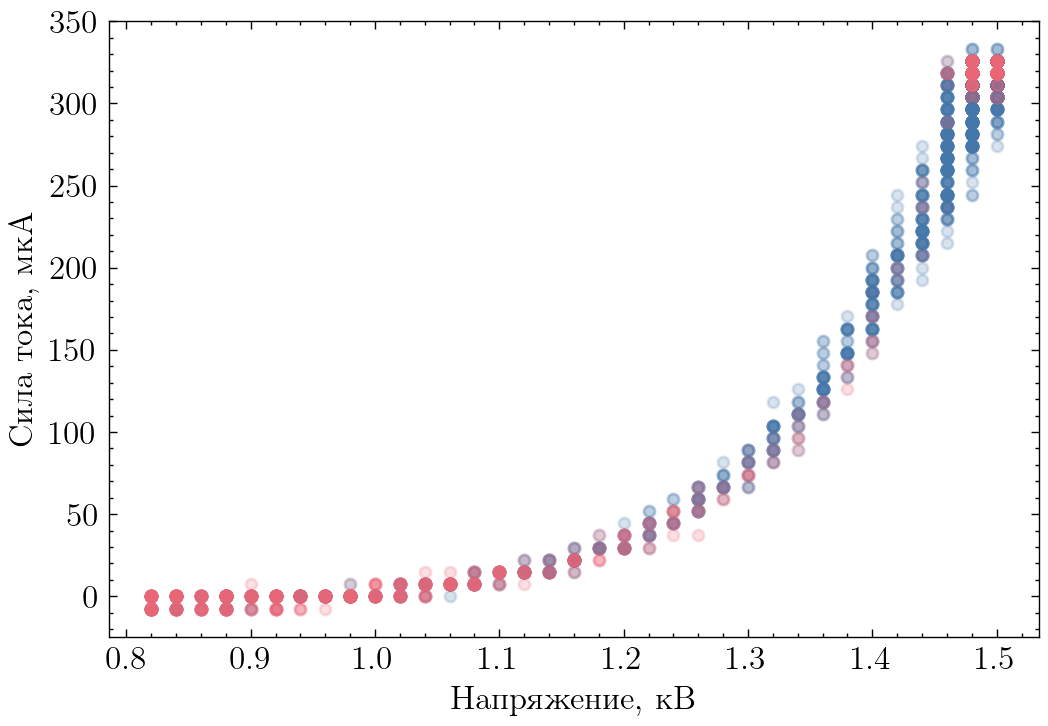

In [56]:
idx = 900
U_min = 800

for i in range(1, 4):
    df = pd.read_csv(f"BOTH-{i}.csv", header = None)
    data = [None, None]
    df = df.loc[lambda x : x[4] > U_min]
    
    data[0] = df.loc[lambda x : x.index < idx]
    data[1] = df.loc[lambda x : x.index >= idx]
    
    for (i, d) in enumerate(data):
        U = d[4] * 1e-3 # кВ
        U_res = d[10]
        R = 26.99e3 # Ом
        I = U_res / R * 1e6 # мкА

        plt.plot(U, I, lw=5, alpha=0.2, ls="", marker="o", markersize=4, color=f"C{i}")
    
    
plt.xlabel(fr"Напряжение, кВ")
plt.ylabel(fr"Сила тока, мкА")
# plt.yscale("log")

plt.savefig("all-VAH-BOTH.png")
plt.show()